In [1]:
import html
import math
import random
import re
import sys

import torch
from datasets import load_dataset, load_from_disk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

sys.path.append("../../")

from models import Transformer
from utils.datasets import TextPairDataCollate, TextPairDataset
from utils.helpers import (
    bleu_score,
    count_params,
    create_pad_mask,
    create_subsequent_mask,
    seq2seq_decode,
)
from utils.tokenizers import BPETokenizer, Tokenizer

### Data preparation

#### 1. Data cleaning

In [ ]:
vi_en_dataset = load_dataset(
    "mt_eng_vietnamese", "iwslt2015-vi-en", cache_dir="datasets"
)


def clean(batch):
    en = html.unescape(batch["translation"]["en"]).lower()
    vi = html.unescape(batch["translation"]["vi"]).lower()

    en = re.sub(r"\s+", " ", en).strip()
    en = " ".join(list(filter(lambda x: len(x), en.split())))
    batch["en"] = en

    vi = re.sub(r"\s+", " ", vi).strip()
    vi = " ".join(list(filter(lambda x: len(x), vi.split())))
    batch["vi"] = vi

    return batch


del vi_en_dataset["validation"]
vi_en_dataset = vi_en_dataset.map(clean, remove_columns="translation")
vi_en_dataset.save_to_disk("datasets/cleaned")

#### 2. Token indexing

In [3]:
tokenizer = BPETokenizer()
tokenizer.load_state_dict(torch.load("tokenizers/bpe.pth"))
vi_en_dataset = load_from_disk("datasets/cleaned")

In [ ]:
def token2idx(batch):
    batch["ids_vi"] = (
        [tokenizer._st2i[tokenizer.sos]]
        + tokenizer(batch["vi"])
        + [tokenizer._st2i[tokenizer.eos]]
    )
    batch["ids_en"] = tokenizer(batch["en"])

    return batch


vi_en_ids = vi_en_dataset.map(
    token2idx, remove_columns=vi_en_dataset.column_names["train"]
)

In [ ]:
max_length = 256

vi_en_ids = vi_en_ids.filter(
    lambda batch: 2 < len(batch["ids_vi"]) <= max_length
    and 1 <= len(batch["ids_en"]) <= max_length
)

In [20]:
train, val = vi_en_ids["train"].train_test_split(test_size=0.01).values()
vi_en_ids.update({"train": train, "val": val})
vi_en_ids.save_to_disk("datasets/processed_ids_splits")

#### 3. Experiments

In [6]:
vi_en_ids = load_from_disk("datasets/processed_ids_splits")
vi_en_ids

DatasetDict({
    train: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 131805
    })
    test: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 1268
    })
    val: Dataset({
        features: ['ids_vi', 'ids_en'],
        num_rows: 1332
    })
})

In [87]:
print("".join(tokenizer.decode(vi_en_ids["train"]["ids_en"][56])))

and , you know , built the society that we now live in .


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vocab_size = len(tokenizer)
n_heads = 4
n_blocks = 2
d_model = 64
d_k = d_v = d_model // n_heads
d_ff = 4 * d_model
p_drop = 0.1

model = Transformer(
    vocab_size, n_heads, max_length, n_blocks, d_model, d_ff, d_k, d_v, p_drop
).to(device)
count_params(model)

optimizer = Adam(model.parameters(), lr=0.0002, betas=(0.98, 0.99))
scheduler = ExponentialLR(optimizer, 0.99**0.125)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer._st2i[tokenizer.pad])

Total: 2,311,936 parameters.
Trainable: 2,311,936 parameters.


In [13]:
lre = torch.linspace(-6, -0.6, 1000)

In [ ]:
tp_collate = TextPairDataCollate(tokenizer)

val_dl = DataLoader(
    TextPairDataset(vi_en_ids["val"]["ids_en"][:10], vi_en_ids["val"]["ids_vi"][:10]),
    batch_size=32,
    pin_memory=True,
    shuffle=False,
    collate_fn=tp_collate,
)

losses = []
lrs = []
i = 0
while i < len(lre):
    for src, src_lens, tgt, tgt_lens in val_dl:
        src, src_lens, tgt, tgt_lens = (
            src.to(device),
            src_lens.to(device),
            tgt.to(device),
            tgt_lens.to(device),
        )

        src_mask = create_pad_mask(src_lens)
        tgt_0 = tgt[:, :-1]
        tgt_0_mask = create_subsequent_mask(
            tgt_lens, pad_mask=create_pad_mask(tgt_lens)
        )
        tgt_1 = tgt[:, 1:].contiguous().view(-1)

        optimizer.param_groups[0]["lr"] = math.exp(lre[i])
        logits = model(src, src_mask, tgt_0, tgt_0_mask)
        loss = loss_fn(logits.view(-1, vocab_size), tgt_1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(optimizer.param_groups[0]["lr"])

        losses.append(loss.item())
        lrs.append(lre[i])
        i += 1
        if i == len(lre):
            break

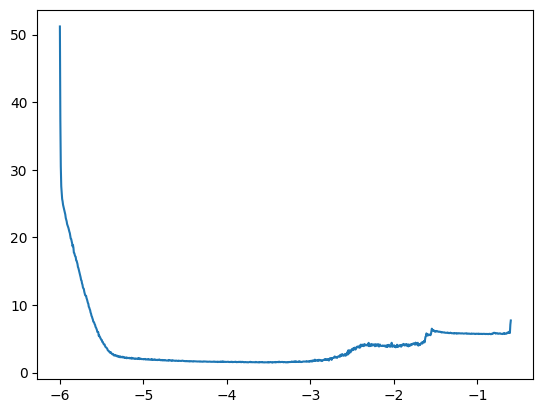

In [15]:
import matplotlib.pyplot as plt

plt.plot(lrs, losses)

### Test tokenizer

In [5]:
raw_corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]
tknr = BPETokenizer(raw_corpus, target_size=100)

Building vocabulary...: 100%|██████████| 100/100 [00:00<00:00, 14991.01it/s]


In [6]:
tknr = BPETokenizer()
tknr.load_state_dict(torch.load("tokenizers/bpe.pth"))

In [8]:
print(
    tknr.decode(
        tknr(
            [
                "<sos> Hôm nay cứ để nó thế này thôi, mai xem tiếp :D <eos> <pad>",
                "To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:",
            ]
        )
    )[0]
)

['<unk>', 'so', 's', '<unk>', ' hôm', ' nay', ' cứ', ' để', ' nó', ' thế', ' này', ' thôi', ',', ' mai', ' xem', ' tiếp', ' :', 'd', ' ', '<unk>', 'e', 'os', '<unk>', ' ', '<unk>', 'pad', '<unk>']


In [ ]:
a = [1, 3, 5, 6, 9, 7, 8, 9, 8, 10, 8]
b = [1, 3, 5, 6, 8, 10, 3, 8]

print(bleu_score([a], [b], tknr))
print(sentence_bleu([b], a, (1.0,)))

0.6363636363636364
0.6363636363636364


### Test training

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_length = 20
vocab_size = 21
n_heads = 4
n_blocks = 2
d_model = 16
d_k = d_v = d_model // n_heads
d_ff = 4 * d_model
p_drop = 0.2

model = Transformer(
    vocab_size, n_heads, max_length, n_blocks, d_model, d_ff, d_k, d_v, p_drop
).to(device)
count_params(model)

optimizer = Adam(model.parameters(), lr=0.002, betas=(0.98, 0.99), weight_decay=0.01)
scheduler = ExponentialLR(optimizer, 0.999**0.125)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

Total: 15,333 parameters.
Trainable: 15,333 parameters.


In [37]:
sample_data = torch.arange(1, 21).view(-1, 10).to(device)
sample_lens = torch.LongTensor([10] * 2).to(device)
sample_mask1 = create_pad_mask(sample_lens).to(device)
sample_mask2 = create_subsequent_mask(sample_lens - 1).to(device)

In [ ]:
model.train()
for i in range(5000):
    logits = model(sample_data, sample_mask1, sample_data[:, :-1], sample_mask2)
    #    print(logits.argmax(-1))
    loss = loss_fn(logits.reshape(-1, logits.size(-1)), sample_data[:, 1:].reshape(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())
    scheduler.step()

In [39]:
src_data = torch.arange(8, 18).unsqueeze(0).to(device)
src_lens = torch.LongTensor([10]).to(device)
src_mask = create_pad_mask(src_lens).to(device)

tgt_data = torch.LongTensor([[2, 3, 4]]).to(device)
tgt_lens = torch.LongTensor([3]).to(device)
tgt_mask = create_subsequent_mask(tgt_lens).to(device)

model.eval()
with torch.inference_mode():
    encoder_outputs = model.encode(src_data, src_mask)
    for i in range(12):
        logits = model.generate(tgt_data, tgt_mask, encoder_outputs, src_mask)
        # print(logits.argmax(-1))
        n = logits.softmax(-1).argmax(-1)[:, [-1]]
        tgt_data = torch.cat([tgt_data, n], dim=1).to(device)
        tgt_lens += 1
        tgt_mask = create_subsequent_mask(tgt_lens).to(device)

print(tgt_data)

tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 18, 19, 20, 18, 19, 20]],
       device='cuda:0')


### Test trained model (overfitted on val dataset)

In [2]:
tokenizer = BPETokenizer()
tokenizer.load_state_dict(torch.load("tokenizers/bpe.pth"))

In [4]:
max_length = 256

In [3]:
vi_en_ids = load_from_disk("datasets/processed_ids_splits")

vi_en_ids = vi_en_ids.filter(
    lambda batch: 2 < len(batch["ids_vi"]) <= max_length
    and 1 <= len(batch["ids_en"]) <= max_length
)

tp_collate = TextPairDataCollate(tokenizer)

Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed_ids_splits/train/cache-b811cae21ec9df1a.arrow
Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed_ids_splits/test/cache-df2584775ba9f3ae.arrow
Loading cached processed dataset at /media/4TDISK/vinhdq/transformers/experiments/en-vi-translation/datasets/processed_ids_splits/val/cache-b752e855779655fd.arrow


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = len(tokenizer)
n_heads = 8
n_blocks = 6
d_model = 256
d_k = d_v = d_model // n_heads
d_ff = 4 * d_model
p_drop = 0.1

model = Transformer(
    vocab_size, n_heads, max_length, n_blocks, d_model, d_ff, d_k, d_v, p_drop
).to(device)
model.load_state_dict(
    torch.load(f"checkpoints/translation-{d_model}-{n_blocks}-{n_heads}.pth")
)

<All keys matched successfully>

In [5]:
val_dl = DataLoader(
    TextPairDataset(vi_en_ids["val"]["ids_en"], vi_en_ids["val"]["ids_vi"]),
    batch_size=10,
    pin_memory=True,
    shuffle=False,
    collate_fn=tp_collate,
)

In [6]:
def translate_one_sentence(
    model: nn.Module,
    tokenizer: Tokenizer,
    device: str,
    sentence: str,
    max_tokens: int = 20,
):
    return "".join(
        tokenizer.decode(
            seq2seq_decode(
                model, tokenizer, sentence, max_tokens=max_tokens, device=device
            )[0].tolist()
        )
    )

In [29]:
src, src_len, tgt, tgt_len = val_dl.dataset[random.randint(0, len(val_dl.dataset) - 1)]
hehe = "".join(tokenizer.decode(src))
print(hehe)
print("".join(tokenizer.decode(tgt)))
print(translate_one_sentence(model, tokenizer, device, hehe, 100))

these rapid collapses are especially likely where there 's a mismatch between available resources and resource consumption , or a mismatch between economic outlays and economic potential .
<sos>những vụ sụp đổ nhanh chóng này đặc biêt giống với sự không tương xứng giữa những tài nguyên sẵn có và tài nguyên tiêu thụ , hay bất tương xứng giữa phí tổn kinh tế và tiềm năng kinh tế .<eos>
<sos>những vụ sụp đổ nhanh chóng này đặc biêt giống với sự không tương xứng giữa những tài nguyên sẵn có và tài nguyên tiêu thụ , hay bất tương xứng giữa phí tổn kinh tế và tiềm năng kinh tế .<eos>


In [152]:
translate_one_sentence(
    model,
    tokenizer,
    device,
    "i 'm so tired of feeling this way",
    max_tokens=100,
)

'<sos>tôi chán ngấy với cảm giác chán như thế này .<eos>'